In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [62]:
# Load the dataset
df = pd.read_csv("pima_cleaned.csv")

### 1. Preprocessing

In [63]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


In [64]:
# Number of columns excluding the last one
num_cols = len(df.columns) - 1

# Check each column
for i in range(num_cols):
    col = df.iloc[:, i]  # Select column i
    min_val = col.min()
    max_val = col.max()

    # Check if normalized
    if min_val < 0 or max_val > 1:
        print(f"Column {df.columns[i]} not normalized. Min: {min_val}, Max: {max_val}")
    else:
        print(f"Column {df.columns[i]} normalized. Min: {min_val}, Max: {max_val}")

Column Pregnancies normalized. Min: 0.0, Max: 1.0
Column Glucose normalized. Min: 0.0, Max: 1.0
Column BloodPressure normalized. Min: 0.0, Max: 0.9999999999999998
Column SkinThickness normalized. Min: 0.0, Max: 1.0
Column Insulin normalized. Min: 0.0, Max: 1.0
Column BMI normalized. Min: 0.0, Max: 0.8425357873210637
Column DiabetesPedigreeFunction normalized. Min: 0.0, Max: 0.9999999999999998
Column Age normalized. Min: 0.0, Max: 1.0


In [65]:
normalized_dataset = df.drop('Outcome', axis=1).values

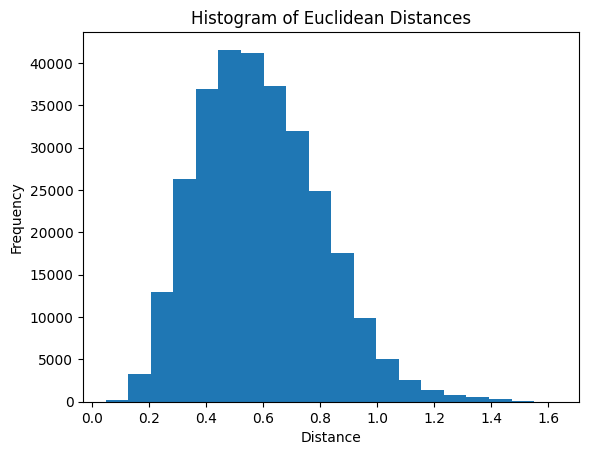

In [67]:
# محاسبه فاصله اقلیدسی بین نمونه‌ها
# Calculate Euclidean distance between samples
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance += (row1[i] - row2[i])**2
    return np.sqrt(distance)

distances = []
for i in range(len(normalized_dataset)):
    for j in range(i+1, len(normalized_dataset)):
        distances.append(euclidean_distance(normalized_dataset[i], normalized_dataset[j]))

# نمایش هیستوگرام فواصل اقلیدسی
# Display histogram of Euclidean distances
plt.hist(distances, bins=20)
plt.title('Histogram of Euclidean Distances') # (فواصل اقلیدسی)
plt.xlabel('Distance') # (فاصله)
plt.ylabel('Frequency') # (فراوانی)
plt.show()

### 2. Hierarchical Clustering (AGNES)

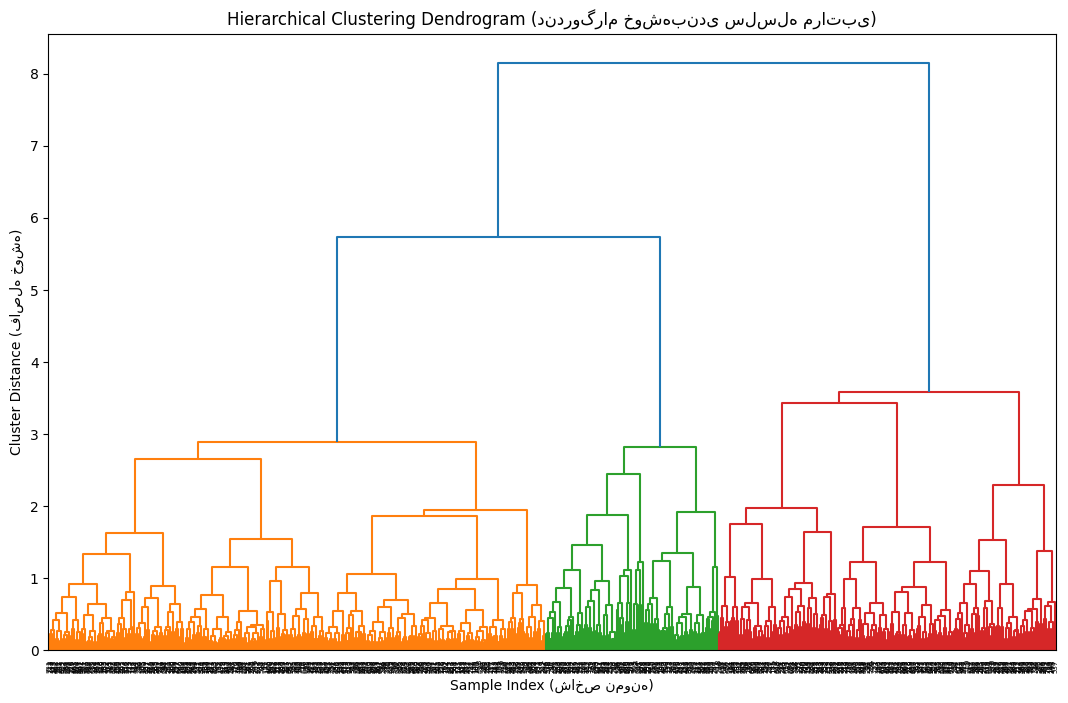

In [69]:
# خوشه‌بندی سلسله مراتبی (AGNES)
# Hierarchical Clustering (AGNES)
linked = linkage(normalized_dataset, 'ward')

# رسم دندروگرام برای تجسم خوشه‌بندی سلسله مراتبی
# Plot dendrogram to visualize hierarchical clustering
plt.figure(figsize=(13, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (دندروگرام خوشه‌بندی سلسله مراتبی)')
plt.xlabel('Sample Index (شاخص نمونه)')
plt.ylabel('Cluster Distance (فاصله خوشه)')
plt.show()

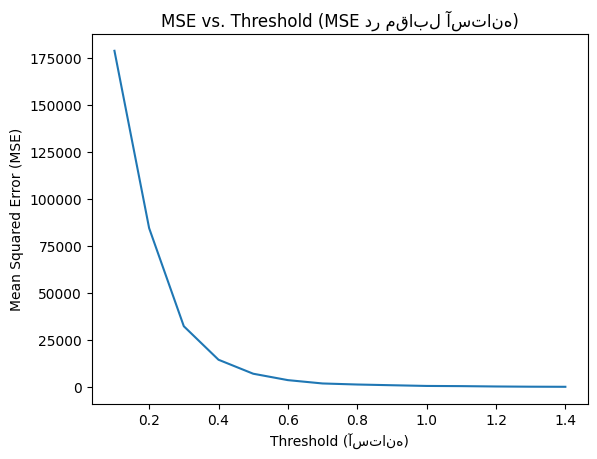

In [71]:
# محاسبه MSE برای آستانه‌های مختلف برای ارزیابی کیفیت خوشه‌بندی
# Calculate MSE for different thresholds to evaluate clustering quality
mse_values = []
thresholds = np.arange(0.1, 1.5, 0.1)

for threshold in thresholds:
    clusters = fcluster(linked, threshold, criterion='distance')
    mse = mean_squared_error(df['Outcome'], clusters)
    mse_values.append(mse)

# نمایش نمودار MSE برای تعیین آستانه بهینه
# Plot MSE vs. Threshold to determine optimal threshold
plt.plot(thresholds, mse_values)
plt.title('MSE vs. Threshold (MSE در مقابل آستانه)')
plt.xlabel('Threshold (آستانه)')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

In [72]:
# تعیین آستانه و تعداد خوشه‌های بهینه بر اساس MSE
# Determine optimal threshold and number of clusters based on MSE
optimal_threshold = thresholds[np.argmin(mse_values)]
optimal_clusters = len(np.unique(fcluster(linked, optimal_threshold, criterion='distance')))

print(f"آستانه بهینه: {optimal_threshold}")
print(f"تعداد خوشه‌های بهینه: {optimal_clusters}")

آستانه بهینه: 1.4000000000000001
تعداد خوشه‌های بهینه: 22
